Refer to the [Wikipedia article](https://en.wikipedia.org/wiki/Self-avoiding_walk) on self-avoiding walks for a good primer on the subject.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import itertools
import random

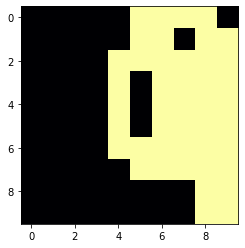

In [266]:
dimensions = 2
D = dimensions
z = 10

start = [0, 0]
choices = []

for n in range(dimensions):
    for y in [-1, 1]:
        delta = np.zeros(dimensions).astype(np.int)
        delta[n] = y
        choices.append(delta)

steps = []
pos = np.array(start)
lengths = []
walks = []
for x in range(1000):
    grid = np.zeros([z] * D)
    for t in range(z**2):
#         print(0<pos+delta[0]<z)
#         print(grid[tuple(pos+delta[0])])
        possible = list(filter(lambda c: (0<=pos+c).all() and (pos+c<z).all() and grid[tuple(pos+c)] == 0, choices))
        if possible:
            delta = random.choice(possible)
            steps.append(delta)
            pos += delta
            pos = np.clip(pos, 0, z-1)
            grid[tuple(pos)] = 1
        else:
            lengths.append(t)
            walks.append(grid)
            break

plt.imshow(grid, cmap='inferno')

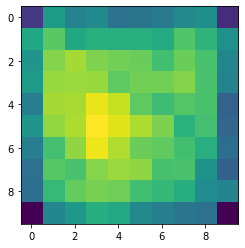

In [265]:
plt.imshow(np.average(np.stack(walks), axis=0))

(array([ 34.,   6.,  44.,  11.,   0.,  45.,  18.,  61.,  25.,   0.,  73.,
         33.,  77.,  42.,   0.,  88.,  38., 100.,  52.,   0.,  73.,  51.,
         66.,  24.,  36.]),
 array([ 4. ,  4.8,  5.6,  6.4,  7.2,  8. ,  8.8,  9.6, 10.4, 11.2, 12. ,
        12.8, 13.6, 14.4, 15.2, 16. , 16.8, 17.6, 18.4, 19.2, 20. , 20.8,
        21.6, 22.4, 23.2, 24. ]),
 <BarContainer object of 25 artists>)

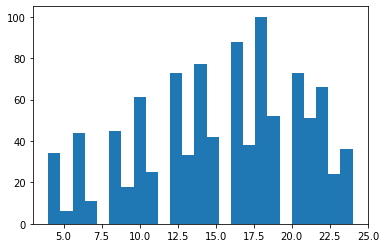

In [263]:
plt.hist(lengths, bins=25)